<a href="https://colab.research.google.com/github/nihilkottal/GIS_class/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### My Analysis

As a foreign national in New Jersey,US I would like to reasearch and know what kind of business/product to set up based on Race/Ethnicty, Median Income, age of the population and also based on the availability of public transport.

### Resources

I Obtained the population data (Race and ethnicity)  from US Census website https://data.census.gov/all/tables?t=-03&g=010XX00US,$0400000,$1400000&y=2021

The geographical NJ shapefile can be downlaoded from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341

Public transport shapefiles for NJ can be downloaded from https://njogis-newjersey.opendata.arcgis.com/datasets/e6701817be974795aecc7f7a8cc42f79_0/explore


In [33]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

In [34]:
! pip install geopandas
!pip install mapclassify
import geopandas as gpd
import mapclassify

## Mapping the NJ Sate

In [35]:
! wget -q -O nj-counties.zip https://docs.google.com/uc?id=1xJDhcRCkgv7k4tNCa72Oog5bohV6dTB2&export=download
zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping
njC=gpd.read_file('nj_counties.shp')

<Axes: >

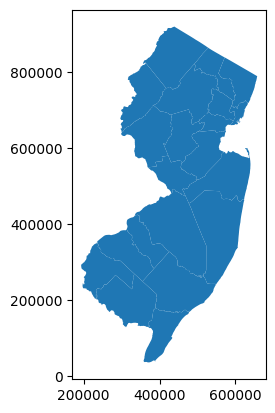

In [36]:
#plot the map
njC.plot()

In [37]:
njC.head(2)

,COUNTY,COUNTY_LAB,CO,GNIS_NAME,GNIS,FIPSSTCO,FIPSCO,ACRES,SQ_MILES,POP2010,...,POP1990,POP1980,POPDEN2010,POPDEN2000,POPDEN1990,POPDEN1980,REGION,Shape_Leng,Shape_Area,geometry
0,ATLANTIC,Atlantic County,ATL,County of Atlantic,882270,34001,1,390815.404215,610.649069,274549,...,275372,204615,450,414,451,335,COASTAL,650228.153906,1.702385e+10,"POLYGON ((443056.010 311529.770, 443068.440 31..."
1,BERGEN,Bergen County,BER,County of Bergen,882271,34003,3,153490.275182,239.828555,905116,...,829592,849843,3774,3686,3459,3544,NORTHEASTERN,443326.122021,6.686010e+09,"POLYGON ((656200.963 783614.366, 656141.127 78..."


### Uploading the population data


In [38]:
import pandas as pd
! wget -q -O nj-counties.zip https://github.com/nihilkottal/GIS_class/raw/main/ACSDT5YSPT2021.B01001_2023-09-12T121735.zip

zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping

##Droping the columns with the below mentioned keyword
exclude_columns_with_string = 'Annotation'
exclude_columns_with_string2 = 'Margin'

njC_population=pd.read_csv('ACSDT5YSPT2021.B01001-Data.csv',header = 1,usecols=lambda column: exclude_columns_with_string not in column and exclude_columns_with_string2 not in column)

In [39]:
njC_population.head(2)

,Geography,Geographic Area Name,Race/Ethnic Group,Population Groups,Estimate!!Total:,Estimate!!Total:!!Male:,Estimate!!Total:!!Male:!!Under 5 years,Estimate!!Total:!!Male:!!5 to 9 years,Estimate!!Total:!!Male:!!10 to 14 years,Estimate!!Total:!!Male:!!15 to 17 years,...,Estimate!!Total:!!Female:!!55 to 59 years,Estimate!!Total:!!Female:!!60 and 61 years,Estimate!!Total:!!Female:!!62 to 64 years,Estimate!!Total:!!Female:!!65 and 66 years,Estimate!!Total:!!Female:!!67 to 69 years,Estimate!!Total:!!Female:!!70 to 74 years,Estimate!!Total:!!Female:!!75 to 79 years,Estimate!!Total:!!Female:!!80 to 84 years,Estimate!!Total:!!Female:!!85 years and over,Unnamed: 200
0,0500000US34001,"Atlantic County, New Jersey",32,Asian Indian alone or in any combination,7014,3748,259,166,267,123,...,129,108,52,111,267,37,137,21,17,NaN
1,0500000US34003,"Bergen County, New Jersey",13,Asian Indian alone,35041,17407,1362,984,1203,681,...,1083,338,368,326,449,427,308,165,115,NaN


### Cleaning the data

In [40]:
#Creating a new column for Population groups with uniform ethnic name.

def categorize_text(text):
    if 'asian' in text.lower():
        return 'Indian'
    elif 'chinese' in text.lower():
        return 'Chinese'
    elif 'filipino' in text.lower():
        return 'Filipino'
    elif 'korean' in text.lower():
        return 'Korean'
    elif 'pakistani' in text.lower():
        return 'Pakistani'
    elif 'japanese' in text.lower():
        return 'Japanese'
    else:
        return 'Other'

# Apply the function to create a new column
njC_population['category'] = njC_population['Population Groups'].apply(categorize_text)


In [41]:
##Checking the newly created column
njC_population['category'].unique()

array(['Indian', 'Chinese', 'Filipino', 'Korean', 'Japanese', 'Pakistani'],
      dtype=object)

In [42]:
##Grouping people based on their age
cols = ['Estimate!!Total:!!Male:!!Under 5 years', 'Estimate!!Total:!!Male:!!5 to 9 years','Estimate!!Total:!!Male:!!10 to 14 years','Estimate!!Total:!!Male:!!15 to 17 years']
cols2 = ['Estimate!!Total:!!Male:!!18 and 19 years', 'Estimate!!Total:!!Male:!!20 years', 'Estimate!!Total:!!Male:!!21 years', 'Estimate!!Total:!!Male:!!22 to 24 years', 'Estimate!!Total:!!Male:!!25 to 29 years', 'Estimate!!Total:!!Male:!!30 to 34 years', 'Estimate!!Total:!!Male:!!35 to 39 years', 'Estimate!!Total:!!Male:!!40 to 44 years', 'Estimate!!Total:!!Male:!!45 to 49 years', 'Estimate!!Total:!!Male:!!50 to 54 years', 'Estimate!!Total:!!Male:!!55 to 59 years', 'Estimate!!Total:!!Male:!!60 and 61 years', 'Estimate!!Total:!!Male:!!62 to 64 years', 'Estimate!!Total:!!Male:!!65 and 66 years']
cols3 = ['Estimate!!Total:!!Male:!!67 to 69 years', 'Estimate!!Total:!!Male:!!70 to 74 years', 'Estimate!!Total:!!Male:!!75 to 79 years', 'Estimate!!Total:!!Male:!!80 to 84 years', 'Estimate!!Total:!!Male:!!85 years and over']
cols4 = ['Estimate!!Total:!!Female:!!Under 5 years', 'Estimate!!Total:!!Female:!!5 to 9 years', 'Estimate!!Total:!!Female:!!10 to 14 years', 'Estimate!!Total:!!Female:!!15 to 17 years']
cols5 = ['Estimate!!Total:!!Female:!!18 and 19 years', 'Estimate!!Total:!!Female:!!20 years', 'Estimate!!Total:!!Female:!!21 years', 'Estimate!!Total:!!Female:!!22 to 24 years', 'Estimate!!Total:!!Female:!!25 to 29 years', 'Estimate!!Total:!!Female:!!30 to 34 years', 'Estimate!!Total:!!Female:!!35 to 39 years', 'Estimate!!Total:!!Female:!!40 to 44 years', 'Estimate!!Total:!!Female:!!45 to 49 years', 'Estimate!!Total:!!Female:!!50 to 54 years', 'Estimate!!Total:!!Female:!!55 to 59 years', 'Estimate!!Total:!!Female:!!60 and 61 years', 'Estimate!!Total:!!Female:!!62 to 64 years', 'Estimate!!Total:!!Female:!!65 and 66 years']
cols6 = ['Estimate!!Total:!!Female:!!67 to 69 years', 'Estimate!!Total:!!Female:!!70 to 74 years', 'Estimate!!Total:!!Female:!!75 to 79 years', 'Estimate!!Total:!!Female:!!80 to 84 years', 'Estimate!!Total:!!Female:!!85 years and over']
njC_population['Male_age_17'] = njC_population[cols].sum(axis=1)
njC_population['Male_age_upto_66'] = njC_population[cols2].sum(axis=1)
njC_population['Male_age_above_66'] = njC_population[cols3].sum(axis=1)
njC_population['Female_age_17'] = njC_population[cols4].sum(axis=1)
njC_population['Female_age_upto_66'] = njC_population[cols5].sum(axis=1)
njC_population['Female_age_above_66'] = njC_population[cols6].sum(axis=1)


In [43]:
##Selecting only the required columns for our analysis
selected_columns = ['Geography', 'Geographic Area Name','Race/Ethnic Group','Population Groups','category','Estimate!!Total:','Estimate!!Total:!!Male:','Male_age_17','Male_age_upto_66','Male_age_above_66','Estimate!!Total:!!Female:','Female_age_17','Female_age_upto_66','Female_age_above_66']
njC_population = njC_population[selected_columns].copy()

In [44]:
njC_population.dtypes

Geography                    object
Geographic Area Name         object
Race/Ethnic Group             int64
Population Groups            object
category                     object
Estimate!!Total:              int64
Estimate!!Total:!!Male:       int64
Male_age_17                   int64
Male_age_upto_66              int64
Male_age_above_66             int64
Estimate!!Total:!!Female:     int64
Female_age_17                 int64
Female_age_upto_66            int64
Female_age_above_66           int64
dtype: object

In [45]:
##Editing the Geographic area Name column so that we can merge the data with our plot

njC_population['Comma_count'] = njC_population['Geographic Area Name'].str.count(',')
njC_population1 = njC_population[njC_population['Comma_count'] == 1]
njC_population1[['County', 'State']] = njC_population1['Geographic Area Name'].str.split(',', expand=True)

njC_population2 = njC_population[njC_population['Comma_count'] == 2]
njC_population2[['Town','County', 'State']] = njC_population2['Geographic Area Name'].str.split(',', expand=True)
column_name_to_remove = 'Town'
njC_population2 = njC_population2.drop(columns=column_name_to_remove)

njC_population = pd.concat([njC_population1, njC_population2])


len(njC_population)

<ipython-input-45-a85a8e658622>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  njC_population1[['County', 'State']] = njC_population1['Geographic Area Name'].str.split(',', expand=True)
<ipython-input-45-a85a8e658622>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  njC_population1[['County', 'State']] = njC_population1['Geographic Area Name'].str.split(',', expand=True)
<ipython-input-45-a85a8e658622>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

111

In [46]:
##Getting rid of leading and trailing whitespace

njC_population['County'] = njC_population['County'].str.strip()

##Aggregate the data to so that many to one relationship is avoided

grouped = njC_population.groupby(['category','County']).agg({'Estimate!!Total:': 'sum', 'Estimate!!Total:!!Male:': 'sum','Male_age_17': 'sum','Male_age_upto_66': 'sum','Estimate!!Total:!!Female:': 'sum','Female_age_17': 'sum','Female_age_upto_66': 'sum','Female_age_above_66': 'sum'}).reset_index()
grouped.head(2)

,category,County,Estimate!!Total:,Estimate!!Total:!!Male:,Male_age_17,Male_age_upto_66,Estimate!!Total:!!Female:,Female_age_17,Female_age_upto_66,Female_age_above_66
0,Chinese,Bergen County,94724,45632,11243,28748,49092,8866,33058,7168
1,Chinese,Camden County,14698,6895,2084,4135,7803,2362,4533,908


In [47]:
####Merging Datasets

grouped.rename(columns={'County': 'COUNTY_LAB'}, inplace=True)
merged_data = pd.merge(njC, grouped, on='COUNTY_LAB',how='outer',indicator=True)
len(merged_data)
merged_data.dtypes

41

COUNTY                         object
COUNTY_LAB                     object
CO                             object
GNIS_NAME                      object
GNIS                           object
FIPSSTCO                       object
FIPSCO                         object
ACRES                         float64
SQ_MILES                      float64
POP2010                         int64
POP2000                         int64
POP1990                         int64
POP1980                         int64
POPDEN2010                      int64
POPDEN2000                      int64
POPDEN1990                      int64
POPDEN1980                      int64
REGION                         object
Shape_Leng                    float64
Shape_Area                    float64
geometry                     geometry
category                       object
Estimate!!Total:              float64
Estimate!!Total:!!Male:       float64
Male_age_17                   float64
Male_age_upto_66              float64
Estimate!!To

In [48]:
merged_data._merge.value_counts()

both          33
left_only      8
right_only     0
Name: _merge, dtype: int64

In [49]:
merged_data[merged_data._merge!='both']

,COUNTY,COUNTY_LAB,CO,GNIS_NAME,GNIS,FIPSSTCO,FIPSCO,ACRES,SQ_MILES,POP2010,...,category,Estimate!!Total:,Estimate!!Total:!!Male:,Male_age_17,Male_age_upto_66,Estimate!!Total:!!Female:,Female_age_17,Female_age_upto_66,Female_age_above_66,_merge
10,CAPE MAY,Cape May County,CAP,County of Cape May,882274,34009,9,183126.574240,286.135272,97265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
11,CUMBERLAND,Cumberland County,CUM,County of Cumberland,882275,34011,11,321150.321572,501.797378,156898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
15,GLOUCESTER,Gloucester County,GLO,County of Gloucester,882277,34015,15,215166.893094,336.198271,288288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,HUNTERDON,Hunterdon County,HUN,County of Hunterdon,882228,34019,19,279885.206384,437.320635,128349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
24,OCEAN,Ocean County,OCE,County of Ocean,882279,34029,29,485078.440831,757.935064,576567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
26,SALEM,Salem County,SAL,County of Salem,882233,34033,33,222158.656047,347.122900,66083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
29,SUSSEX,Sussex County,SUS,County of Sussex,882236,34037,37,342730.853674,535.516959,149265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,WARREN,Warren County,WAR,County of Warren,882237,34041,41,232061.359022,362.595874,108692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [50]:
merged_data.COUNTY_LAB[merged_data._merge!='both']
#aok: possibly a problem--why these didnt merge?
#nihil : The race and ethnicity data that I downloaded does not contain these counties. Hence, they are missing.

10      Cape May County
11    Cumberland County
15    Gloucester County
19     Hunterdon County
24         Ocean County
26         Salem County
29        Sussex County
33        Warren County
Name: COUNTY_LAB, dtype: object

In [51]:
merged_data.COUNTY_LAB[merged_data._merge=='both']
#aok: again possibly a problem--county is not unique
#Nihil : Each county has multiple ethnicites. Hence, the repetation. In the code I have filtered
        #out only for Indians and then plotted the map.

0       Atlantic County
1         Bergen County
2         Bergen County
3         Bergen County
4         Bergen County
5         Bergen County
6     Burlington County
7         Camden County
8         Camden County
9         Camden County
12         Essex County
13         Essex County
14         Essex County
16        Hudson County
17        Hudson County
18        Hudson County
20        Mercer County
21        Mercer County
22      Monmouth County
23      Monmouth County
25       Passaic County
27      Somerset County
28      Somerset County
30         Union County
31         Union County
32         Union County
34        Morris County
35        Morris County
36     Middlesex County
37     Middlesex County
38     Middlesex County
39     Middlesex County
40     Middlesex County
Name: COUNTY_LAB, dtype: object

In [52]:
##Creating a population density column to look at the population spread

merged_data['pop_density(people/Sq Miles)'] = merged_data['Estimate!!Total:']/merged_data['SQ_MILES']
merged_data["Total_ethnicity_pop"] = merged_data.groupby('category')['Estimate!!Total:'].transform('sum')
merged_data['Percentage'] = (merged_data['Estimate!!Total:']/merged_data['Total_ethnicity_pop'])*100



***Now lets plot the overall population distribution for each ethnicities and see which ethnicity has the most population***

<Axes: >

Text(0.5, 1.0, 'Map of Indian ethnicity population')

<Axes: >

Text(0.5, 1.0, 'Map of Chinese ethnicity population')

<Axes: >

Text(0.5, 1.0, 'Map of Filipino ethnicity population')

<Axes: >

Text(0.5, 1.0, 'Map of Japanese ethnicity population')

<Axes: >

Text(0.5, 1.0, 'Map of Korean ethnicity population')

<Axes: >

Text(0.5, 1.0, 'Map of Pakistani ethnicity population')

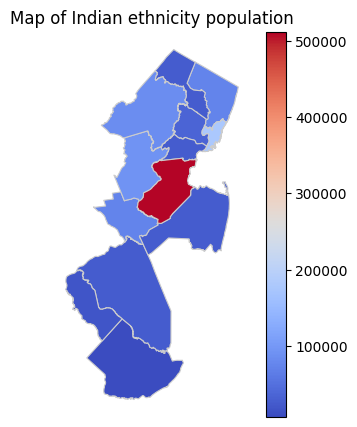

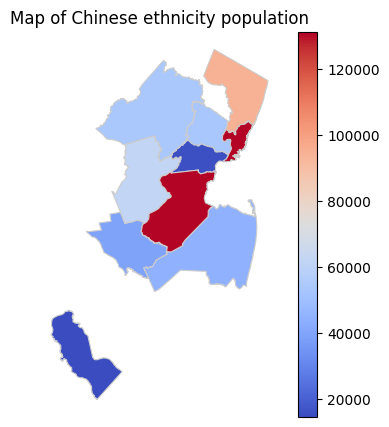

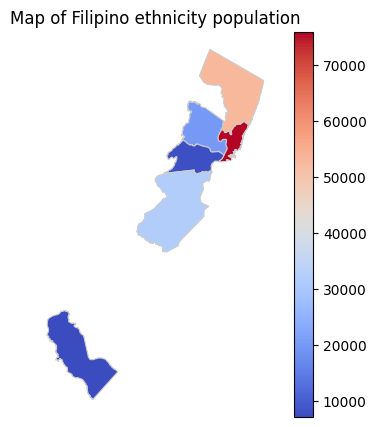

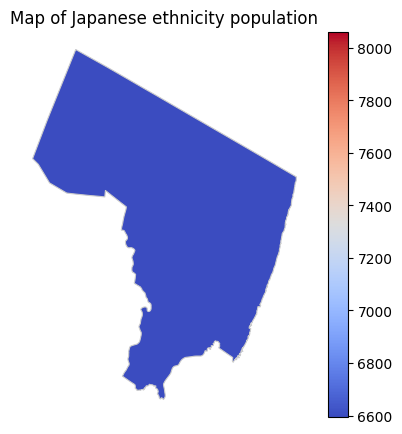

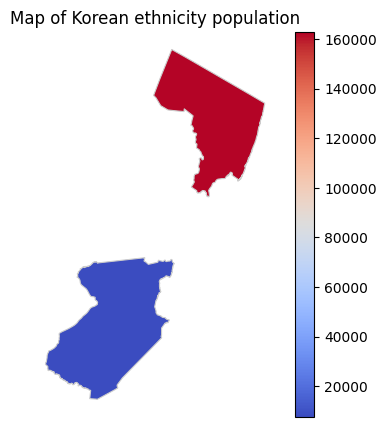

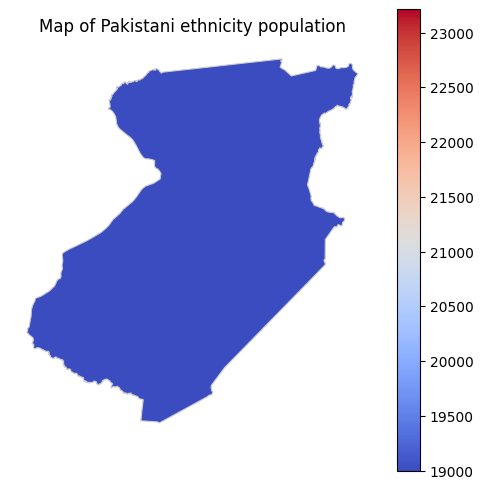

In [55]:
# Removing nan values
merged_data = merged_data[merged_data['category'].notna()]

# Get a list of unique ethnicity
ethnicity = merged_data['category'].unique()

# Create separate maps (facets) for each category
for category in ethnicity:
    subset = merged_data[merged_data['category'] == category]

    # Create a new plot for each category
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    subset.plot(ax=ax,column = 'Estimate!!Total:' ,cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True)

    # Set title and labels
    ax.set_title(f'Map of {category} ethnicity population')
    ax.set_axis_off()

# Adjust spacing between subplots
plt.tight_layout()

# Show all the facets
plt.show()




Text(0.5, 1.0, 'Population density of Indians')

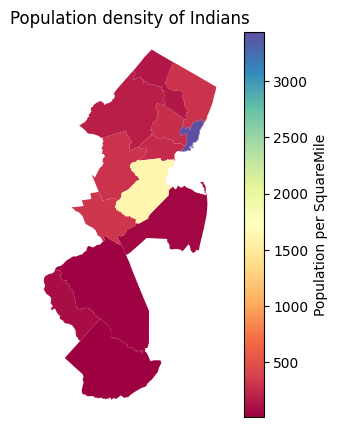

In [74]:
##Since the indian population is more lets deep dive into distribution and population density of the indian population

indian = merged_data[merged_data['category'] == 'Indian']
ax = indian.plot(column = 'pop_density(people/Sq Miles)',cmap = 'Spectral', legend = True,figsize =(5,5),legend_kwds={"label": "Population per SquareMile"})
ax.set_title(f'Population density of Indians')
ax.set_axis_off()


***it looks like majority of the population live in the northern most part of New Jersey. Lets try to analyse more by plotting people between the age group 17 - 65 as they have more purchasing power.***

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Distribution of age group between 17 and 66')

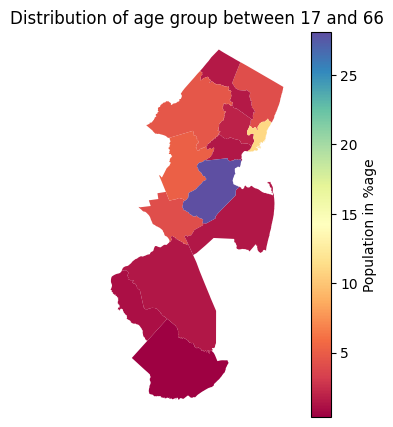

In [78]:
#Lets add both the male and female population between the age group 17 to 65

indian['Adult_age_group'] = indian['Male_age_upto_66'] + indian['Female_age_upto_66']
indian['percentage_adult'] = (indian['Adult_age_group'] / indian['Total_ethnicity_pop']) * 100

#Lets plot the map
base = indian.plot(column = 'percentage_adult',cmap = 'Spectral', legend = True,figsize =(5,5),legend_kwds={"label": "Population in %age"} )
base.set_title(f'Distribution of age group between 17 and 66')
base.set_axis_off()

### PUBLIC TRANSPORT ANALYSIS

Lets try to plot the Bus terminal of NJ Transit and the railway lines across NJ and see how the connectivity looks like

In [79]:
#Downlaoding the Bus terminus shapefile for NJ

! wget -q -O nj-counties.zip https://github.com/nihilkottal/GIS_class/raw/main/Bus_Terminals_of_NJ_Transit.zip
zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping
Bus_terminal=gpd.read_file('Bus_Terminals_of_NJ_Transit.shp')
Bus_terminal = Bus_terminal.to_crs(epsg=3424)

In [80]:
#Downloading the railway line shapefile for NJ

! wget -q -O nj-counties.zip https://github.com/nihilkottal/GIS_class/raw/main/Rail_Lines_of_NJ_Transit.zip
zip_ref = zipfile.ZipFile('nj-counties.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping
Rail_lines=gpd.read_file('NJTRANSIT_RAIL_LINES.shp')


<Axes: >

<Axes: >

Text(0.5, 1.0, 'Bus terminals and Railway line for NJ (Age group 17-66)')

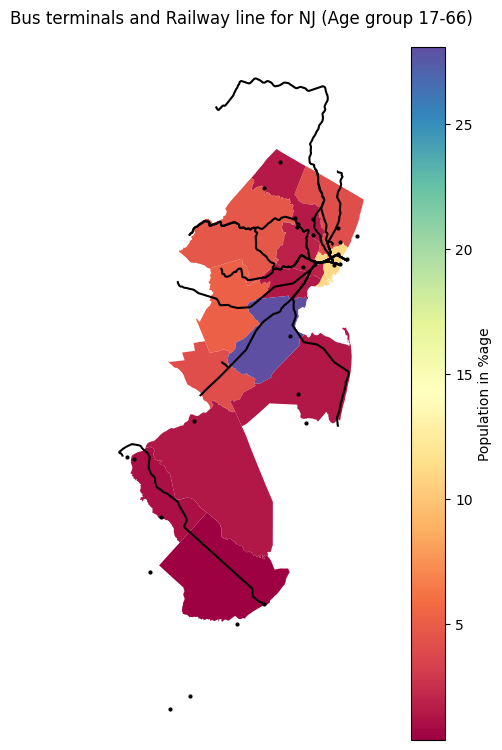

In [82]:
#Plotting both the Bus terminal and Rail line over the base layer of Indian population for the age group 17 - 65 map

base = indian.plot(column = 'percentage_adult',cmap = 'Spectral', legend = True,figsize =(9,9),legend_kwds={"label": "Population in %age"}  )
Bus_terminal.plot(ax = base, color = 'black', markersize = 4,figsize =(10,10) )
Rail_lines.plot(ax = base, color = 'black', markersize = 4,figsize =(10,10) )
base.set_title(f'Bus terminals and Railway line for NJ (Age group 17-66)')
base.set_axis_off()


In [ ]:
  indian = indian.drop('geometry', axis=1)

  from google.colab import files
  indian.to_csv('indian.csv', index=False)
  # Download the file to your local machine
  files.download('indian.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>